### Introduction into Sagemaker Feature Engineering with Python
_________

## *Background*

Direct marketing is used to communicate offers and products to potential customers through various channels (mail, email, phone, etc.). The primary goal is to maximize the impact of marketing campaigns by optimizing resources and targeting individuals who are most likely to respond positively.

## Aplication with Machine Learning

This is where machine learning comes in. The process involves:

* Data Collection: Gathering and storing relevant information in a format suitable for model training.

* Preprocessing: Cleaning and transforming the data to ensure the model receives the best possible information (handling missing data, normalization, etc.).

* Modeling: Choosing and training machine learning models that can predict the likelihood of a contact engaging with a specific marketing offer (e.g., logistic regression, decision trees, etc.).

* Evaluation: Using metrics like accuracy, recall, F1-score, etc., to assess how well the model is performing.

_____

## Preparation 

Let's start by specifying:

* The S3 bucket and prefix that you want to use for training and model df. This should be within the same region as the Notebook Instance, training, and hosting.

**The IAM role arn used to give training and hosting access to your df. See the documentation for how to create these.**

In [1]:
# pip install sagemaker_datawrangler

In [ ]:
import sagemaker_datawrangler           # For interactive data prep widget
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import sagemaker

/opt/conda/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [3]:
import sagemaker
bucket=sagemaker.Session().default_bucket()

In [4]:
bucket # Bucket que se crea cuando creamos nuestro Dominio e iniciaos el Studio Een SageMaker

'sagemaker-us-east-1-221082178761'

In [5]:
prefix = 'mlops/activity-2'


In [6]:
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

In [7]:
role

'arn:aws:iam::221082178761:role/service-role/AmazonSageMaker-ExecutionRole-20250313T190242'

_______
## Data
Let's start by downloading the dfset from github

[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A df-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

In [8]:
!wget https://raw.githubusercontent.com/CamilaCortex/MLOps-AWS/refs/heads/main/Feature_Engineering/Dataset/bank-additional-full.csv --no-check-certificate

--2025-03-16 19:25:42--  https://raw.githubusercontent.com/CamilaCortex/MLOps-AWS/refs/heads/main/Feature_Engineering/Dataset/bank-additional-full.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 5146674 (4.9M) [text/plain]
Saving to: ‘bank-additional-full.csv’

bank-additional-ful 100%[===================>]   4.91M  --.-KB/s    in 0.01s   

2025-03-16 19:25:42 (359 MB/s) - ‘bank-additional-full.csv’ saved [5146674/5146674]



In [9]:
df= pd.read_csv('bank-additional-full.csv')
pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 20)         # Keep the output on one page
df


       age          job  marital            education  default housing loan  \
0       56    housemaid  married             basic.4y       no      no   no   
1       57     services  married          high.school  unknown      no   no   
2       37     services  married          high.school       no     yes   no   
3       40       admin.  married             basic.6y       no      no   no   
4       56     services  married          high.school       no      no  yes   
...    ...          ...      ...                  ...      ...     ...  ...   
41183   73      retired  married  professional.course       no     yes   no   
41184   46  blue-collar  married  professional.course       no      no   no   
41185   56      retired  married    university.degree       no     yes   no   
41186   44   technician  married  professional.course       no      no   no   
41187   74      retired  married  professional.course       no     yes   no   

         contact month day_of_week  duration  campa

Crosstab for job with 'y':
y                    no       yes
job                              
admin.         0.248167  0.291379
blue-collar    0.235745  0.137500
entrepreneur   0.036445  0.026724
housemaid      0.026103  0.022845
management     0.071030  0.070690
retired        0.035187  0.093534
self-employed  0.034804  0.032112
services       0.099759  0.069612
student        0.016417  0.059267
technician     0.164523  0.157328
unemployed     0.023804  0.031034
unknown        0.008017  0.007974


Crosstab for marital with 'y':
y               no       yes
marital                     
divorced  0.113166  0.102586
married   0.612783  0.545690
single    0.272190  0.349138
unknown   0.001861  0.002586


Crosstab for education with 'y':
y                          no       yes
education                              
basic.4y             0.102550  0.092241
basic.6y             0.057568  0.040517
basic.9y             0.152457  0.101940
high.school          0.232133  0.222198
illiterate     

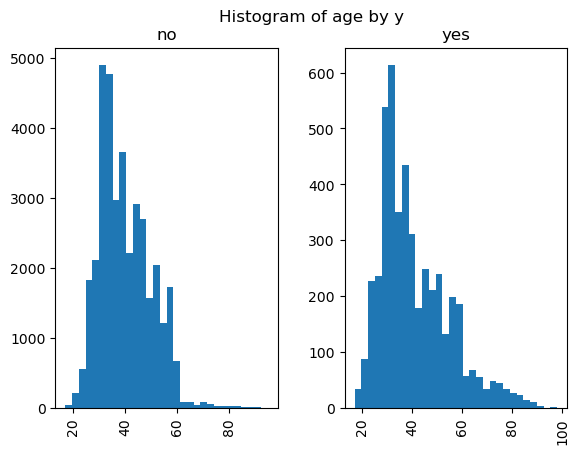

Histogram for duration by 'y':


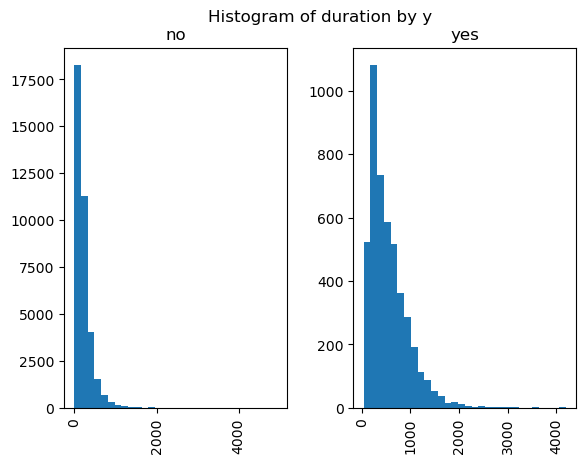

Histogram for campaign by 'y':


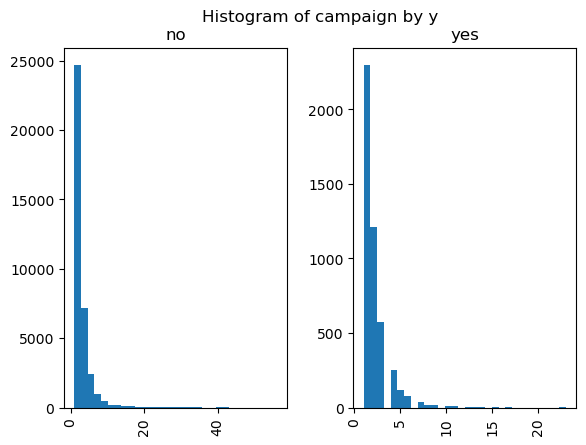

Histogram for pdays by 'y':


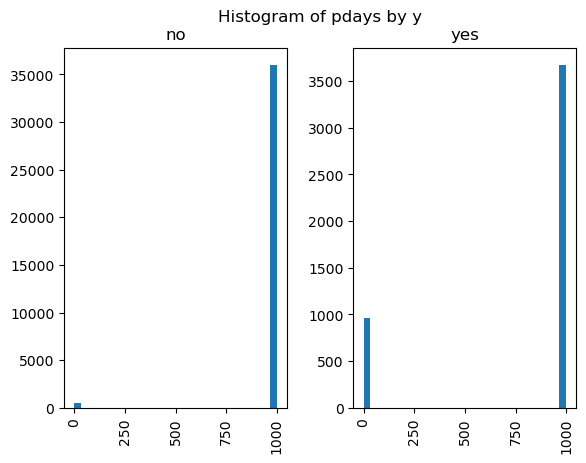

Histogram for previous by 'y':


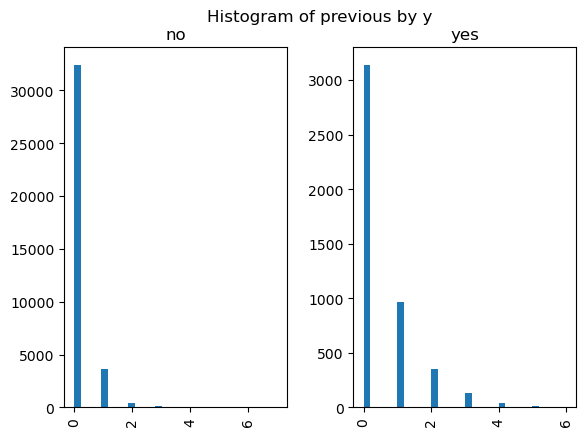

Histogram for emp.var.rate by 'y':


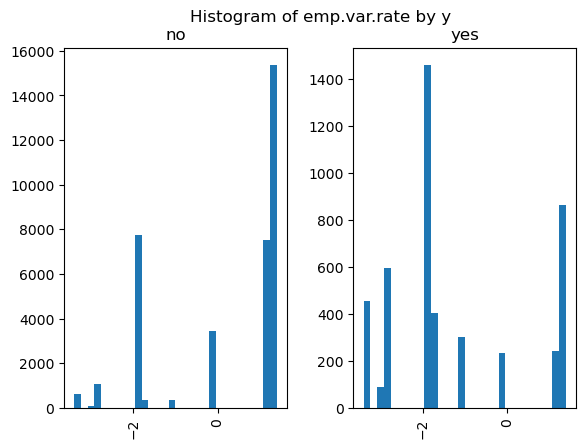

Histogram for cons.price.idx by 'y':


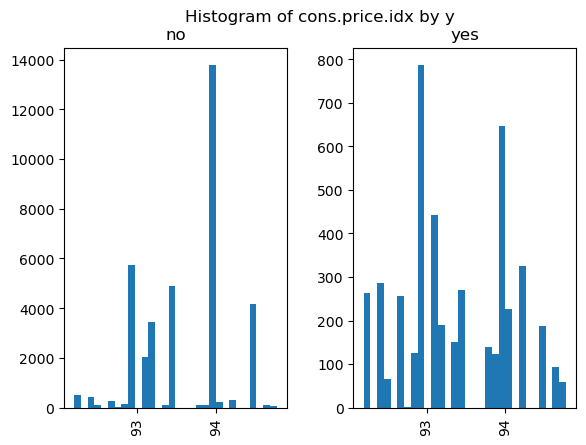

Histogram for cons.conf.idx by 'y':


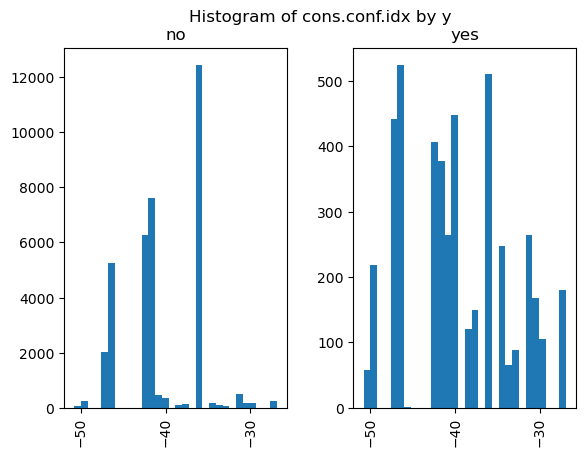

Histogram for euribor3m by 'y':


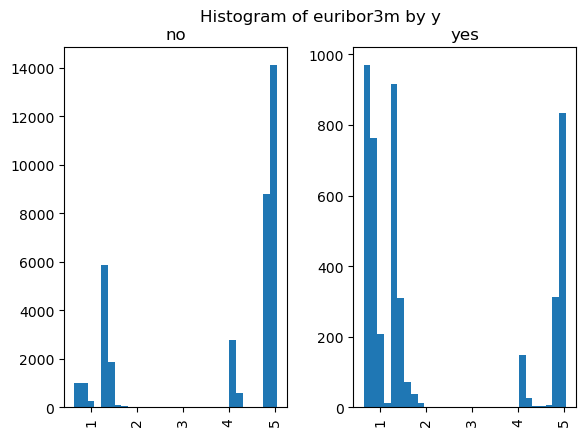

Histogram for nr.employed by 'y':


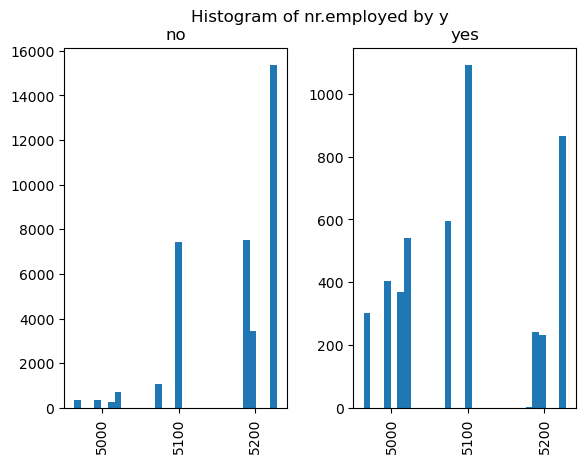

In [10]:
# Iterate through categorical columns (object type) in the DataFrame
for category_column in df.select_dtypes(include=['object']).columns:
    # Skip the target variable 'y'
    if category_column != 'y':
        print(f"Crosstab for {category_column} with 'y':")
        # Create and display crosstab normalized by 'y'
        crosstab_result = pd.crosstab(index=df[category_column], columns=df['y'], normalize='columns')
        print(crosstab_result)
        print("\n")  # Adding a newline for better readability

# Iterate through numerical columns, excluding the target variable 'y'
for numeric_column in df.select_dtypes(exclude=['object']).columns:
    print(f"Histogram for {numeric_column} by 'y':")
    # Create a histogram for the numeric column, grouped by 'y'
    hist = df[[numeric_column, 'y']].hist(by='y', bins=30)
    plt.suptitle(f'Histogram of {numeric_column} by y')  # Add a title to the plot
    plt.show()  # Show the histogram

In [11]:
# Transformation
df['no_previous_contact'] = np.where(df['pdays'] == 999, 1, 0)                                 # Indicator variable to capture when pdays takes a value of 999
df['not_working'] = np.where(np.in1d(df['job'], ['student', 'retired', 'unemployed']), 1, 0)   # Indicator for individuals not actively employed

In [12]:
model_df= pd.get_dummies(df)

In [13]:
model_df

       age  duration  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
0       56       261         1    999         0           1.1          93.994   
1       57       149         1    999         0           1.1          93.994   
2       37       226         1    999         0           1.1          93.994   
3       40       151         1    999         0           1.1          93.994   
4       56       307         1    999         0           1.1          93.994   
...    ...       ...       ...    ...       ...           ...             ...   
41183   73       334         1    999         0          -1.1          94.767   
41184   46       383         1    999         0          -1.1          94.767   
41185   56       189         2    999         0          -1.1          94.767   
41186   44       442         1    999         0          -1.1          94.767   
41187   74       239         3    999         1          -1.1          94.767   

       cons.conf.idx  eurib

In [14]:
model_df= model_df.drop(['duration', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'], axis=1)

In [18]:
int(0.7 * len(model_df)), int(0.9 * len(model_df))

(28831, 37069)

In [19]:
train_df, validation_df, test_df= np.split(model_df.sample(frac=1, random_state=1729), [int(0.7 * len(model_df)), int(0.9 * len(model_df))])   # Randomly sort the dfthen split out first 70%, second 20%, and last 10%


In [20]:
train_df.shape, validation_df.shape, test_df.shape

((28831, 61), (8238, 61), (4119, 61))

In [21]:
test_df.head(5)

       age  campaign  pdays  previous  no_previous_contact  not_working  \
9637    25         1    999         0                    1            0   
36088   28         3    999         0                    1            0   
30101   38         1    999         0                    1            0   
36233   32         1    999         1                    1            0   
4619    40         1    999         0                    1            0   

       job_admin.  job_blue-collar  job_entrepreneur  job_housemaid  \
9637        False            False             False          False   
36088       False            False             False          False   
30101        True            False             False          False   
36233        True            False             False          False   
4619        False            False             False          False   

       job_management  job_retired  job_self-employed  job_services  \
9637            False        False              Fal

In [22]:
pd.concat([train_df['y_yes'], train_df.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([validation_df['y_yes'], validation_df.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)

In [ ]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

___________

## Learning Journey : Feature Engineering with Sagemaker Processing

In [25]:
# Upload to S3 Bucket
from sagemaker import Session
prefix = 'mlops/activity-3'

sess = Session()
input_source = sess.upload_data('./bank-additional-full.csv', bucket=bucket, key_prefix=f'{prefix}/input_data')
input_source

's3://sagemaker-us-east-1-221082178761/mlops/activity-3/input_data/bank-additional-full.csv'

In [26]:
role = get_execution_role()

## Lets started with SageMaker Processing Job

Amazon SageMaker Processing allows you to run steps for data pre- or post-processing, feature engineering, data validation, or model evaluation workloads on Amazon SageMaker. Processing jobs accept data from Amazon S3 as input and store data into Amazon S3 as output.



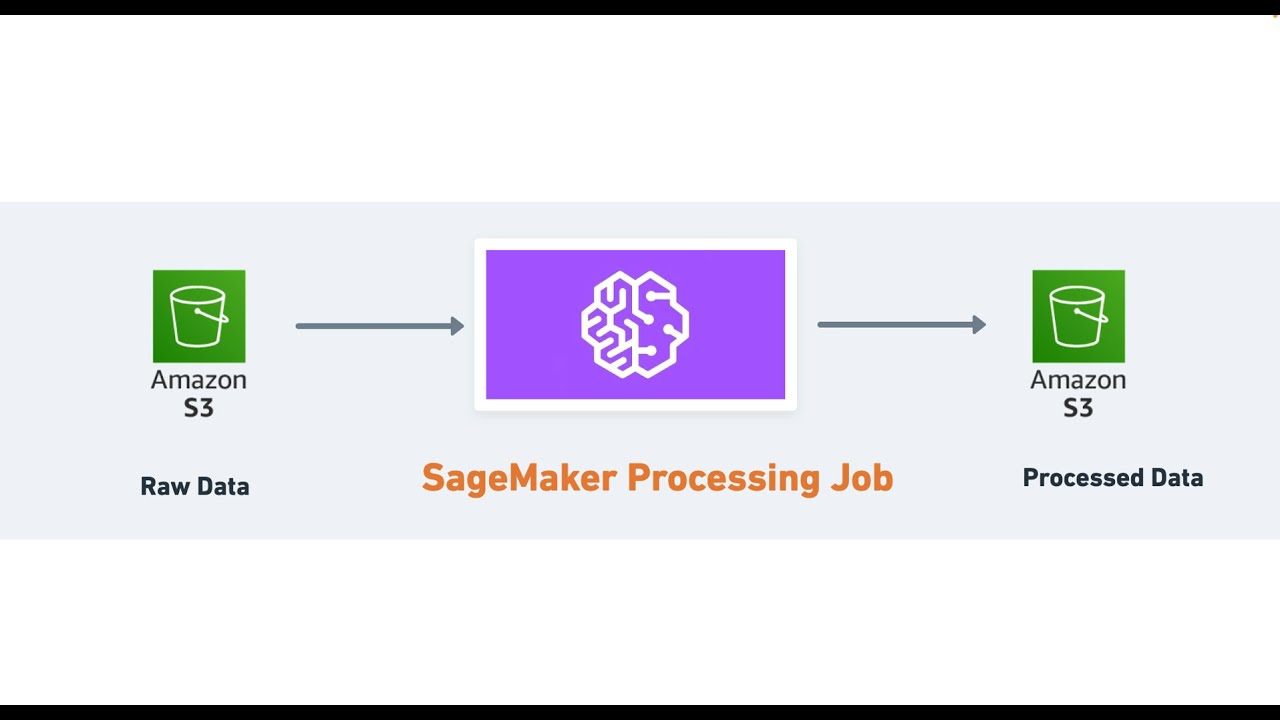

To use SageMaker Processing, simply supply a Python data preprocessing script as shown below (SageMaker Processing Job box). For this example, we're using a SageMaker prebuilt Scikit-learn container, which includes many common functions for processing data. There are few limitations on what kinds of code and operations you can run, and only a minimal contract: input and output data must be placed in specified directories. If this is done, SageMaker Processing automatically loads the input data from S3 and uploads transformed data back to S3 when the job is complete.

Here, we'll import the dataset and transform it with SageMaker Processing, which can be used to process terabytes of data in a SageMaker-managed cluster separate from the instance running your notebook server. In a typical SageMaker workflow, notebooks are only used for prototyping and can be run on relatively inexpensive and less powerful instances, while processing, training and model hosting tasks are run on separate, more powerful SageMaker-managed instances. SageMaker Processing includes off-the-shelf support for Scikit-learn, as well as a Bring Your Own Container option, so it can be used with many different data transformation technologies and tasks.

To use SageMaker Processing, simply supply a Python data preprocessing script as shown below. For this example, we're using a SageMaker prebuilt Scikit-learn container, which includes many common functions for processing data. There are few limitations on what kinds of code and operations you can run, and only a minimal contract: input and output data must be placed in specified directories. If this is done, SageMaker Processing automatically loads the input data from S3 and uploads transformed data back to S3 when the job is complete.

In [28]:
!wget https://raw.githubusercontent.com/CamilaCortex/MLOps-AWS/refs/heads/main/Feature_Engineering/feature_engg_script.py --no-check-certificate

--2025-03-16 20:13:53--  https://raw.githubusercontent.com/CamilaCortex/MLOps-AWS/refs/heads/main/Feature_Engineering/feature_engg_script.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 2292 (2.2K) [text/plain]
Saving to: ‘feature_engg_script.py’

feature_engg_script 100%[===================>]   2.24K  --.-KB/s    in 0s      

2025-03-16 20:13:53 (33.7 MB/s) - ‘feature_engg_script.py’ saved [2292/2292]



In [29]:
train_path = f"s3://{bucket}/{prefix}/train"
validation_path = f"s3://{bucket}/{prefix}/validation"
test_path = f"s3://{bucket}/{prefix}/test"

In [32]:
test_path

's3://sagemaker-us-east-1-221082178761/mlops/activity-3/test'

In [31]:
validation_path

's3://sagemaker-us-east-1-221082178761/mlops/activity-3/validation'

In [30]:
train_path

's3://sagemaker-us-east-1-221082178761/mlops/activity-3/train'

In [33]:
input_source

's3://sagemaker-us-east-1-221082178761/mlops/activity-3/input_data/bank-additional-full.csv'

In [ ]:
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker import get_execution_role


sklearn_processor = SKLearnProcessor(
    framework_version="0.23-1",
    role=get_execution_role(),
    instance_type="ml.m5.large",
    instance_count=1,
    base_job_name='mlops-sklearnprocessing'
)


In [41]:
sklearn_processor.image_uri

'683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn:0.23-1-cpu-py3'

In [42]:
test_path

's3://sagemaker-us-east-1-221082178761/mlops/activity-3/test'

Nota:

* **Explain Service Quota**

In [ ]:
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker import get_execution_role


sklearn_processor = SKLearnProcessor(
    framework_version="0.23-1",
    role=get_execution_role(),
    instance_type="ml.t3.medium",
    instance_count=1,
    base_job_name='mlops-sklearnprocessing'
)

sklearn_processor.run(
    code='feature_engg_script.py',
    # arguments = ['arg1', 'arg2'],
    inputs=[
        ProcessingInput(
            source=input_source,
            destination="/opt/ml/processing/input",
            s3_input_mode="File",
            s3_data_distribution_type="ShardedByS3Key"
        )
    ],
    outputs=[
        ProcessingOutput(
            output_name="train_data",
            source="/opt/ml/processing/output/train",
            destination=train_path,
        ),
        ProcessingOutput(output_name="validation_data", source="/opt/ml/processing/output/validation", destination=validation_path),
        ProcessingOutput(output_name="test_data", source="/opt/ml/processing/output/test", destination=test_path),
    ]
)

................## Processing completed. Exiting.



In [46]:
!aws s3 ls $train_path/

2025-03-16 20:25:51    3545009 train_script.csv


In [47]:
!aws s3 ls $test_path/

2025-03-16 20:25:51     498229 test_script_x.csv
2025-03-16 20:25:51       8238 test_script_y.csv


_____________

### Model Building

In [51]:
role = get_execution_role()

bucket=sagemaker.Session().default_bucket()
prefix = 'mlops/activity-3'
sess = Session()
train_path = f"s3://{bucket}/{prefix}/train"
validation_path = f"s3://{bucket}/{prefix}/validation"
test_path = f"s3://{bucket}/{prefix}/test"

In [52]:
container = sagemaker.image_uris.retrieve(region=boto3.Session().region_name, framework='xgboost', version='latest')

In [53]:
container

'811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest'

In [54]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

In [58]:
s3_input_train

In [56]:
s3_input_train

In [ ]:
xgb = sagemaker.estimator.Estimator(container,
                                    role,
                                    instance_count=1,
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) #Let's to see logs in training jobs

2025-03-16 21:13:54 Starting - Starting the training job...
..25-03-16 21:14:19 Starting - Preparing the instances for training.
..25-03-16 21:14:54 Downloading - Downloading input data.
........16 21:15:24 Downloading - Downloading the training image.
2025-03-16 21:16:50 Training - Training image download completed. Training in progress.
2025-03-16 21:16:50 Uploading - Uploading generated training modelArguments: train
[2025-03-16:21:16:40:INFO] Running standalone xgboost training.
[2025-03-16:21:16:40:INFO] File size need to be processed in the node: 4.35mb. Available memory size in the node: 8567.27mb
[2025-03-16:21:16:40:INFO] Determined delimiter of CSV input is ','
[21:16:40] S3DistributionType set as FullyReplicated
[21:16:41] 28831x59 matrix with 1701029 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2025-03-16:21:16:41:INFO] Determined delimiter of CSV input is ','
[21:16:41] S3DistributionType set as FullyReplicated
[21:16:41] 8238x59 matr

Logs en Cloud Watch...

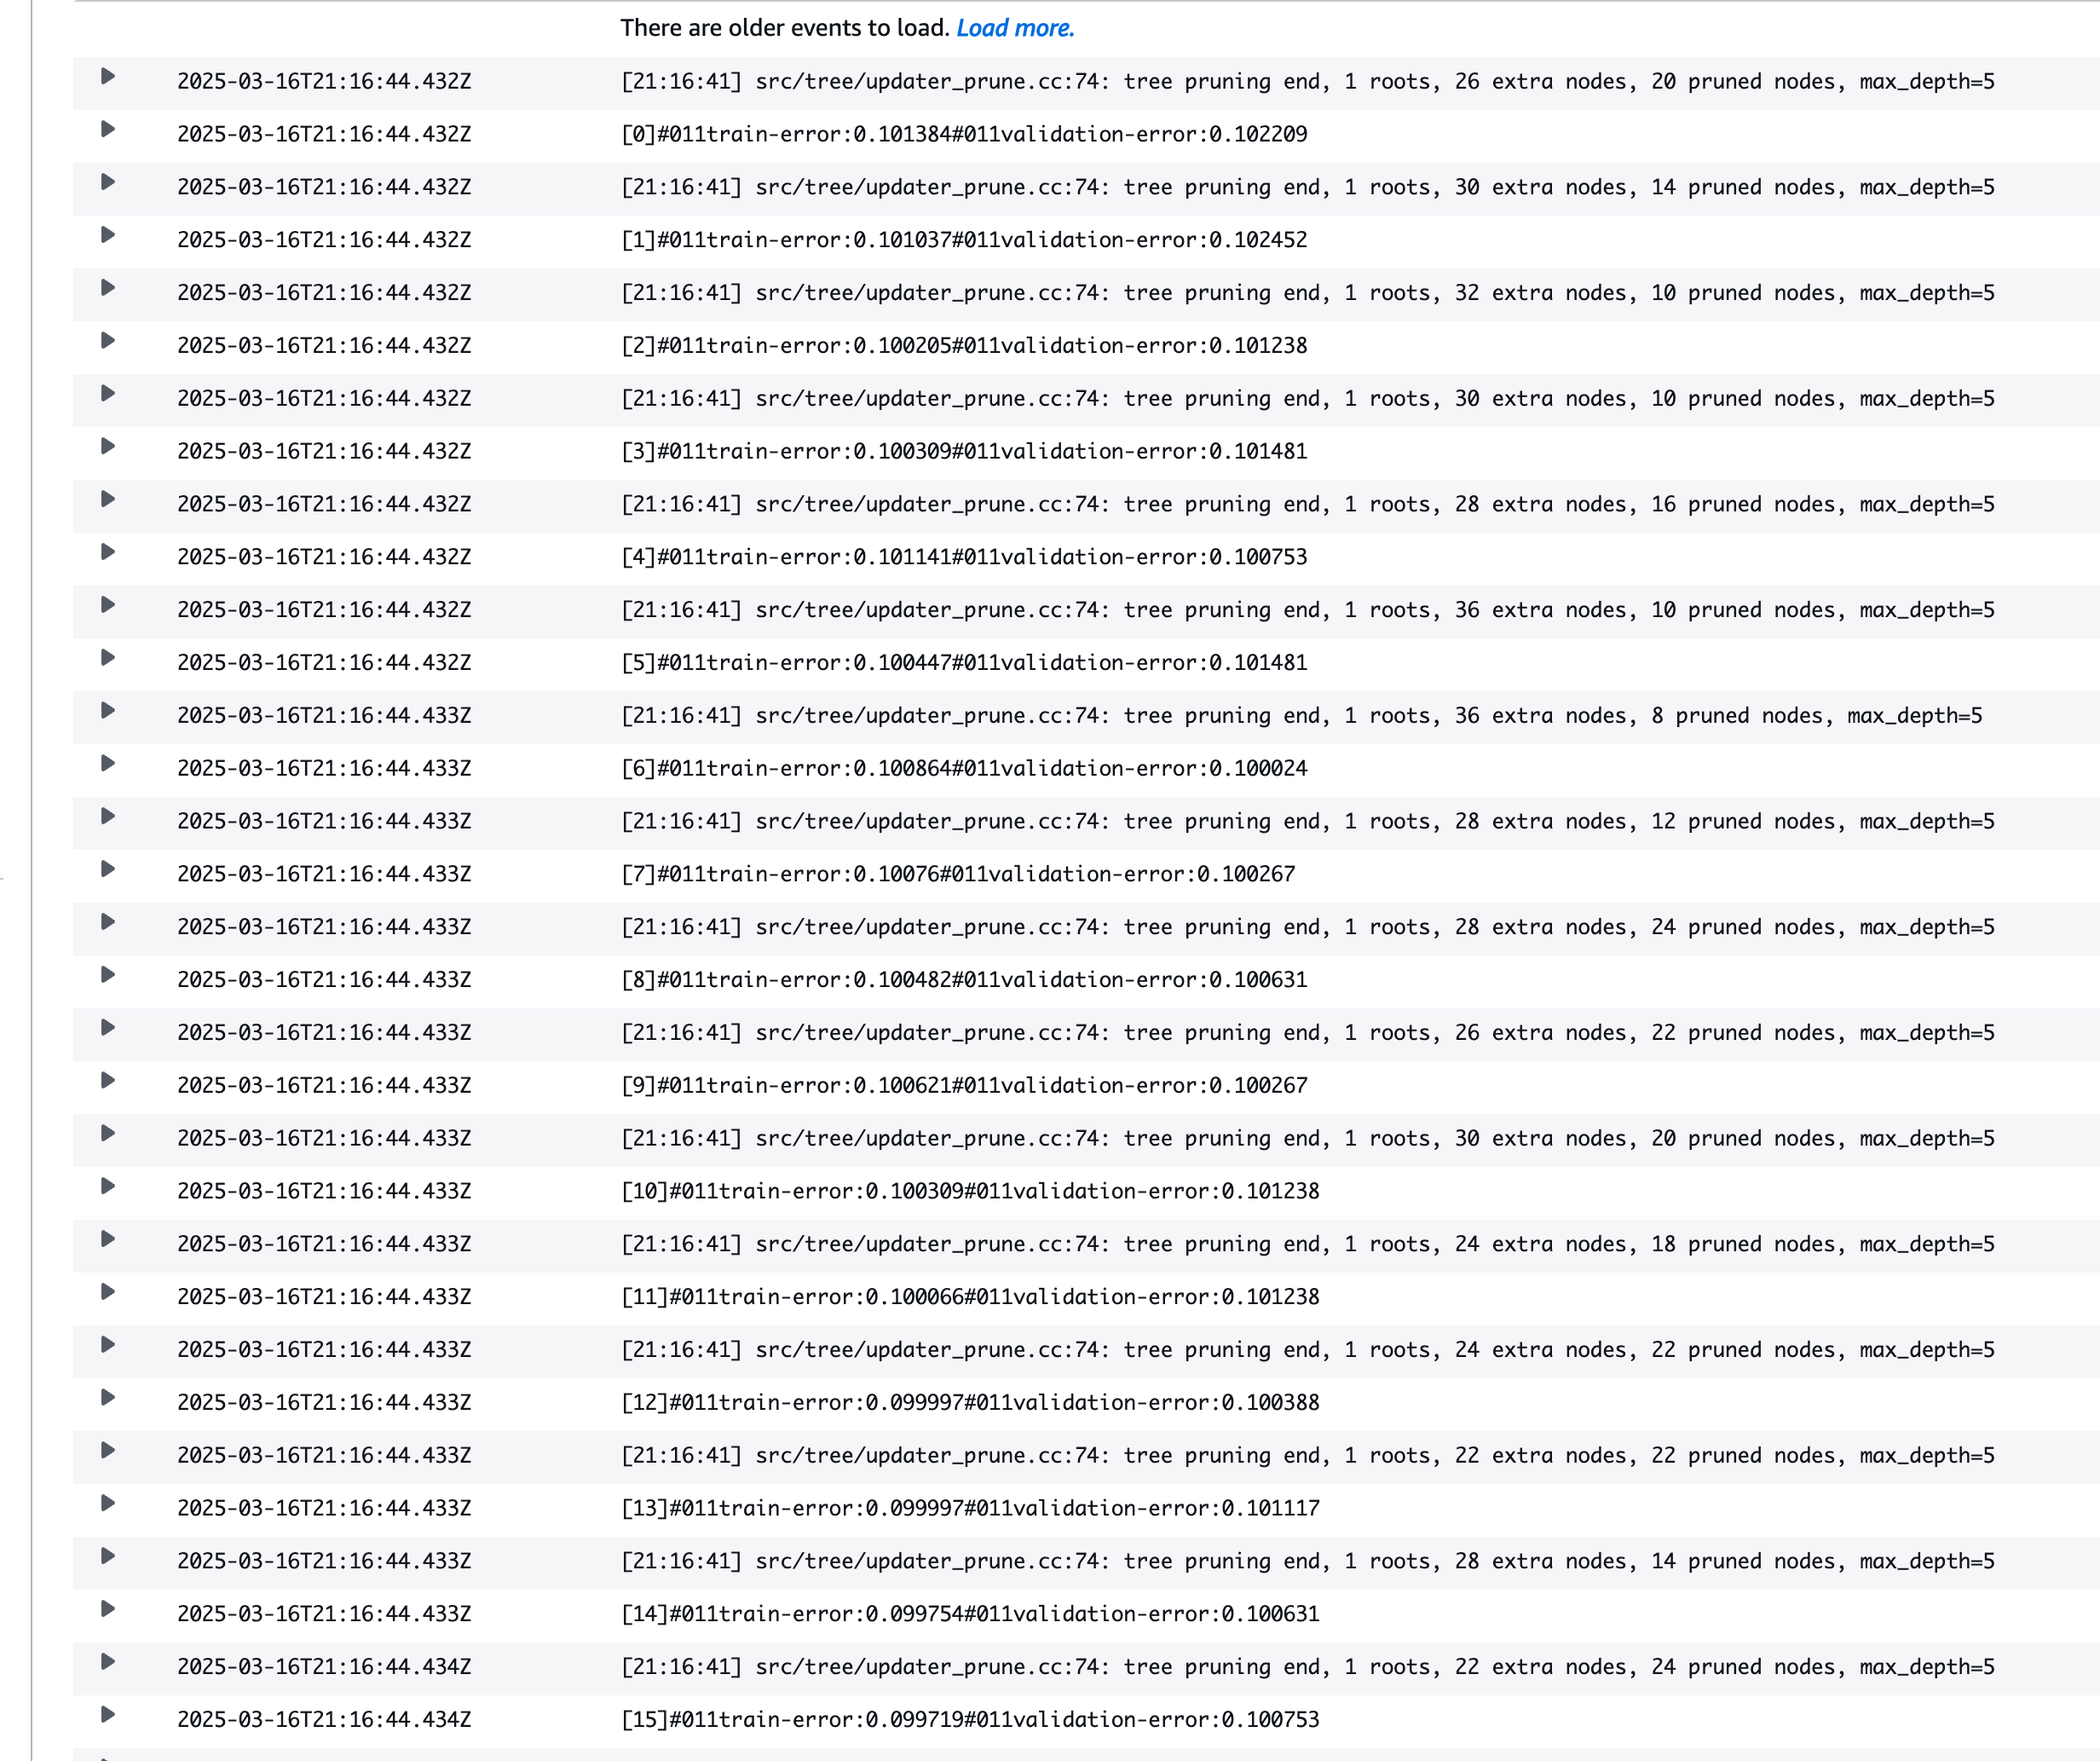

_____
### Make Inferences with Model

In [62]:
!aws s3 ls $test_path

                           PRE test/


In [63]:
test_data_x = pd.read_csv(os.path.join(test_path, 'test_script_x.csv'),header=None)
test_data_y = pd.read_csv(os.path.join(test_path, 'test_script_y.csv'),header=None)

In [66]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge') #Abrir end--points y logs

---------!

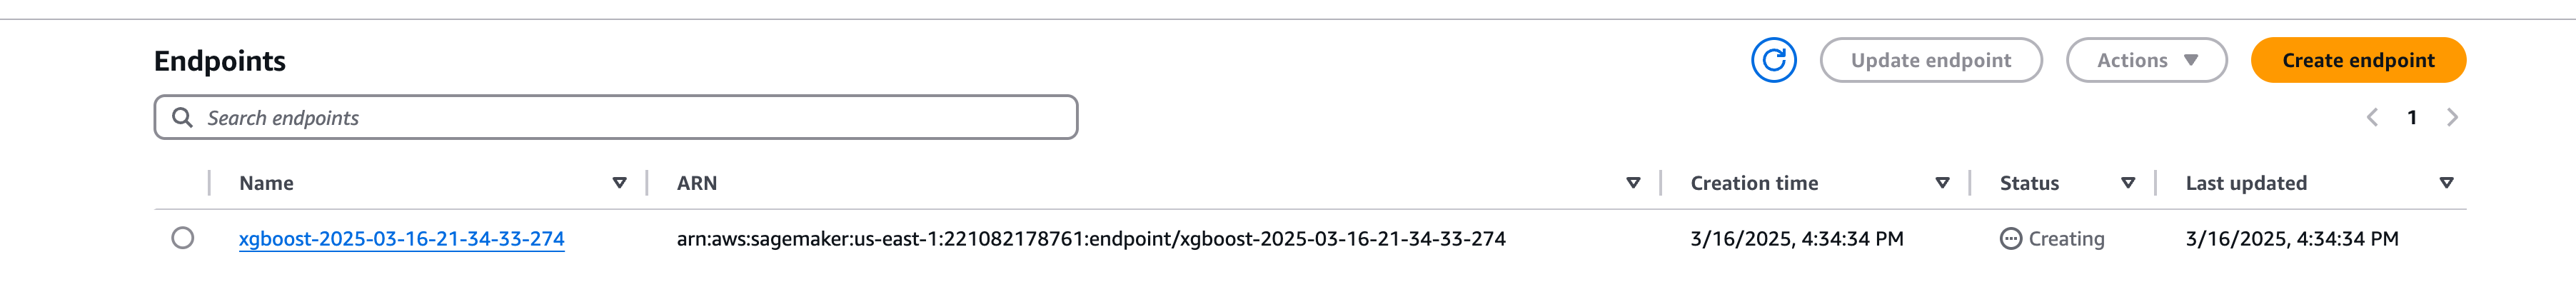

Nota:

Serializer, es una propiedad del predictor se utiliza para definir cómo se deben serializar los datos de entrada antes de ser enviados al endpoint del modelo. La serialización es el proceso de convertir un objeto en un formato que pueda ser almacenado o transmitido, y posteriormente reconstruido.

In [67]:
#Evaluation
xgb_predictor.serializer = sagemaker.serializers.CSVSerializer()

In [ ]:

def predict(data, predictor, rows=500):
    """
    Make predictions using a SageMaker predictor.

    Args:
        data (pd.DataFrame): Input data for predictions.
        predictor (SageMaker Predictor): Predictor for making predictions.
        rows (int): Number of rows per batch for prediction.

    Returns:
        np.ndarray: A NumPy array containing the predictions.
    """
    # Split the data into batches based on the specified number of rows
    split_array = np.array_split(data, int(np.ceil(data.shape[0] / float(rows))))

    # Initialize a list to store predictions
    predictions = []

    # Make predictions for each batch of data
    for array in split_array:
        # Make the prediction and decode the result
        batch_predictions = predictor.predict(array).decode('utf-8')
        # Append predictions to the list
        predictions.append(batch_predictions)

    # Join all predictions into a single string and convert to a NumPy array
    predictions_string = ','.join(predictions)  # Join all predictions into a single string
    return np.fromstring(predictions_string, sep=',')  # Convert to a NumPy array


In [69]:
# Call the function to get predictions
predictions = predict(test_data_x, xgb_predictor)

# Optional: Display the predictions
print("Predictions:", predictions)

Predictions: [0.07548683 0.09506561 0.061901   ... 0.63269192 0.0481618  0.10299101]


In [91]:
np.round(predictions)

array([0., 0., 0., ..., 1., 0., 0.])

In [70]:
pd.crosstab(index=test_data_y[0], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])


predictions   0.0  1.0
actuals               
0            3584   51
1             383  101

In [71]:
xgb_predictor.delete_endpoint(delete_endpoint_config=True)

__________
## Model Deployment

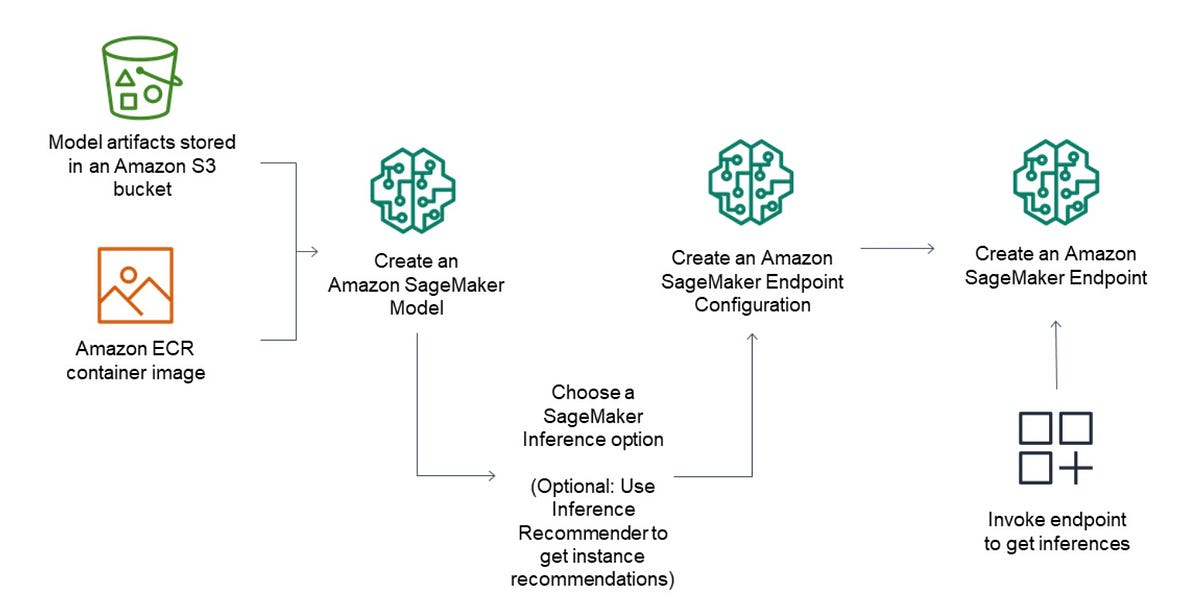

In [76]:
import boto3

client = boto3.client(service_name="sagemaker")
runtime = boto3.client(service_name="sagemaker-runtime")

In [77]:
model_artifacts = xgb.model_data
model_artifacts

's3://sagemaker-us-east-1-221082178761/mlops/activity-3/output/xgboost-2025-03-16-21-13-53-208/output/model.tar.gz'

In [78]:
from time import gmtime, strftime

model_name = "xgboost-serverless" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Model name: " + model_name)

# dummy environment variables
byo_container_env_vars = {"SAGEMAKER_CONTAINER_LOG_LEVEL": "20", "SOME_ENV_VAR": "myEnvVar"}

create_model_response = client.create_model(
    ModelName=model_name,
    Containers=[
        {
            "Image": container,
            "Mode": "SingleModel",
            "ModelDataUrl": model_artifacts,
            "Environment": byo_container_env_vars,
        }
    ],
    ExecutionRoleArn=role,
)

print("Model Arn: " + create_model_response["ModelArn"])

Model name: xgboost-serverless2025-03-16-21-58-26
Model Arn: arn:aws:sagemaker:us-east-1:221082178761:model/xgboost-serverless2025-03-16-21-58-26


Nota:

* SAGEMAKER_CONTAINER_LOG_LEVEL: Este es un nivel de log que controla la verbosidad de los registros dentro del contenedor de SageMaker. Un valor de 20 generalmente indica un nivel de aviso (warning), lo que significa que solo se registrarán advertencias y errores. Otros niveles posibles incluyen 10 para depuración (debug), 30 para información (info), etc.

* SOME_ENV_VAR: Este es un ejemplo de una variable de entorno personalizada. Puedes definir variables de entorno adicionales según las necesidades de tu aplicación o modelo. En este caso, se está utilizando una variable ficticia.

In [81]:
xgboost_epc_name = "mlops-serverless-epc" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName=xgboost_epc_name,
    ProductionVariants=[
        {
            "VariantName": "byoVariant",
            "ModelName": model_name,
            "ServerlessConfig": {
                "MemorySizeInMB": 3072,
                "MaxConcurrency": 1,
            },
        },
    ],
)

print("Endpoint Configuration Arn: " + endpoint_config_response["EndpointConfigArn"]) # Ir a Endpoint configuration settings

Endpoint Configuration Arn: arn:aws:sagemaker:us-east-1:221082178761:endpoint-config/mlops-serverless-epc2025-03-16-22-00-31


In [ ]:
endpoint_name = "xgboost-serverless-ep" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

create_endpoint_response = client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=xgboost_epc_name,
)

print("Endpoint Arn: " + create_endpoint_response["EndpointArn"]) # Ir a Endpoints creados

Endpoint Arn: arn:aws:sagemaker:us-east-1:221082178761:endpoint/xgboost-serverless-ep2025-03-16-22-00-32


In [83]:
# wait for endpoint to reach a terminal state (InService) using describe endpoint
import time

describe_endpoint_response = client.describe_endpoint(EndpointName=endpoint_name)

while describe_endpoint_response["EndpointStatus"] == "Creating":
    describe_endpoint_response = client.describe_endpoint(EndpointName=endpoint_name)
    print(describe_endpoint_response["EndpointStatus"])
    time.sleep(15)

describe_endpoint_response

Creating
Creating
Creating
Creating
Creating
InService


{'EndpointName': 'xgboost-serverless-ep2025-03-16-22-00-32',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:221082178761:endpoint/xgboost-serverless-ep2025-03-16-22-00-32',
 'EndpointConfigName': 'mlops-serverless-epc2025-03-16-22-00-31',
 'ProductionVariants': [{'VariantName': 'byoVariant',
   'DeployedImages': [{'SpecifiedImage': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
     'ResolvedImage': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost@sha256:0c8f830ac408e6dee08445fb60392e9c3f05f790a4b3c07ec22327c08f75bcbf',
     'ResolutionTime': datetime.datetime(2025, 3, 16, 22, 0, 33, 988000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 0,
   'CurrentServerlessConfig': {'MemorySizeInMB': 3072, 'MaxConcurrency': 1}}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2025, 3, 16, 22, 0, 33, 124000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2025, 3, 16, 22, 2, 10, 734000, tzinfo=tzloca

In [84]:
# Endpoint invocation
payload = b"3., 999.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0., 0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   1., 0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1., 0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0., 0.,   1.,   0."

response = runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    Body=payload,
    ContentType="text/csv",
)

print(response["Body"].read().decode())

0.07072833180427551


Note:

* El endpoint nos retorna str, esto habrá que hacerke un castype y un np.round para tener las predicciones entre (0,1). 

client.delete_model(ModelName=model_name)
client.delete_endpoint_config(EndpointConfigName=xgboost_epc_name)
client.delete_endpoint(EndpointName=endpoint_name)

_______
## **Automatic Model Tuning** 

In [104]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {'eta': ContinuousParameter(0, 1),
                            'min_child_weight': ContinuousParameter(1, 10),
                            'alpha': ContinuousParameter(0, 2),
                            'max_depth': IntegerParameter(1, 10)}
objective_metric_name = 'validation:auc'

In [105]:
tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=20,
                            max_parallel_jobs=3)

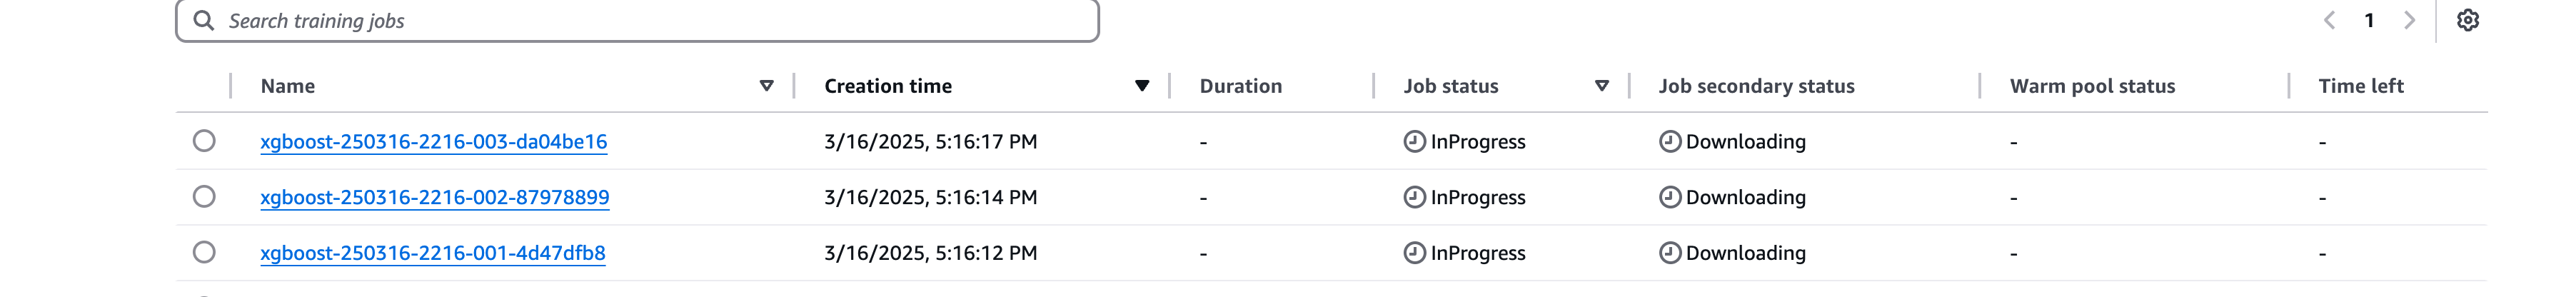

In [106]:
s3_input_validation

In [107]:
tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}) # training jobs e hyperpameters tuning jobs

...................................................................................................!


In [109]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'Completed'

In [110]:
tuner.best_training_job()

'xgboost-250316-2216-013-dcd2227e'

In [111]:
tuner_predictor = tuner.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')


2025-03-16 22:22:54 Starting - Found matching resource for reuse
2025-03-16 22:22:54 Downloading - Downloading the training image
2025-03-16 22:22:54 Training - Training image download completed. Training in progress.
2025-03-16 22:22:54 Uploading - Uploading generated training model
2025-03-16 22:22:54 Completed - Resource reused by training job: xgboost-250316-2216-016-47af4258
---------!

Note:

* El proceso de despliegue (deploy) en Amazon SageMaker se refiere a la etapa en la cual un modelo de machine learning entrenado se pone en producción y se hace accesible para hacer predicciones (inferencias) en nuevos datos. Esto significa que el modelo ya ha sido entrenado y validado, y ahora estás preparando el entorno para que las aplicaciones o usuarios puedan utilizar ese modelo para realizar predicciones en tiempo real o en batch.

* Durante el despliegue, SageMaker crea un endpoint, que es una URL a la que puedes enviar datos y obtener predicciones. Este endpoint se basa en el modelo que se ha entrenado previamente.

* SageMaker se encarga de configurar los servidores necesarios para manejar las solicitudes de predicción y gestionar el escalado (si se requiere).



In [114]:
tuner_predictor.serializer = sagemaker.serializers.CSVSerializer()

In [115]:
test_data_x = pd.read_csv(os.path.join(test_path, 'test_script_x.csv'),header=None)
test_data_y = pd.read_csv(os.path.join(test_path, 'test_script_y.csv'),header=None)

In [116]:
predictions = predict((test_data_x).to_numpy(),tuner_predictor)


In [117]:
pd.crosstab(index=test_data_y[0], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])


predictions   0.0  1.0
actuals               
0            3606   29
1             393   91

# Delete and clean-up

In [118]:
tuner_predictor.delete_endpoint(delete_endpoint_config=True)

### Conclusión


En este notebook, hemos recorrido el flujo completo de un proyecto de machine learning utilizando Amazon SageMaker, abarcando desde la preparación y procesamiento de datos hasta el despliegue de un modelo en producción para inferencias en tiempo real. Este proceso consiste en varios pasos críticos:

Generación de Jobs de Procesamiento de Datos: Comenzamos con la limpieza y transformación de los datos utilizando SageMaker Processing Jobs. Estos trabajos nos permitieron preparar los datos de manera eficiente, asegurando que estuvieran en el formato correcto antes de ser utilizados para el entrenamiento del modelo.

Entrenamiento del Modelo: A continuación, configuramos y ejecutamos un trabajo de entrenamiento, donde utilizamos un modelo de machine learning (como XGBoost, por ejemplo) para aprender a partir de nuestros datos preparados. Este paso es crucial, ya que el rendimiento del modelo depende en gran medida de la calidad de los datos y de la configuración del entrenamiento.

Optimización de Hiperparámetros con Tuning: Implementamos un proceso de ajuste de hiperparámetros para encontrar la mejor configuración de nuestro modelo. Utilizando SageMaker, exploramos automáticamente diversas combinaciones de hiperparámetros, lo que nos permitió mejorar el rendimiento del modelo.

Despliegue del Modelo: Posteriormente, desplegamos el modelo optimizado en un endpoint de SageMaker. Este endpoint proporciona una interfaz accesible para realizar inferencias en tiempo real, lo que permite a las aplicaciones enviar datos y recibir predicciones de manera eficiente.

Inferencias en Tiempo Real: Finalmente, probamos el endpoint creado realizando inferencias en tiempo real. Esto demuestra la capacidad del modelo para entregar resultados instantáneos, facilitando la toma de decisiones basadas en datos.

A través de este flujo de trabajo completo, hemos aprovechado las capacidades de Amazon SageMaker para gestionar todo el ciclo de vida del machine learning. Este framework no solo simplifica el proceso, sino que también proporciona herramientas robustas para escalar y optimizar aplicaciones de machine learning en la nube.